<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 2: Forecasting</h2></center>
<br>

This tutorial we study the practical application of basic forecasting methods in Python. 

<a class="buttom" href=">#Data:-Australian-CPI-Inflation">Data: Australian CPI inflation</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Random-Walk">Random Walk</a> <br>
<a class="buttom" href="#Simple-Exponential-Smoothing">Simple Exponential Smoothing</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook relies on the following imports and settings.



In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Telefonia_movil


In [94]:
data=pd.read_csv('datasets/Telefonia_movil.csv',index_col='Año', parse_dates=True)
data.index=data.index.to_period(freq='Q')+data['Trimestre']-1
data.tail(10)


,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2016Q4,4,15.960.765,6938892,22899656,Oct-Dic 2016
2017Q1,1,14.630.269,6209983,20840252,Ene-Mar 2017
2017Q2,2,15.315.167,6293563,21608730,Abr-Jun 2017
2017Q3,3,15.106.275,6308373,21414647,Jul-Sept 2017
2017Q4,4,14.164.552,5380710,19545262,Oct-Dic 2017
2018Q1,1,13.423.580,5850985,19274565,Ene-Mar 2018
2018Q2,2,14.240.217,6027374,20267591,Abr-Jun 2018
2018Q3,3,14.574.305,6108477,20682782,Jul-Sept 2018
2018Q4,4,14.915.060,6613685,21528745,Oct-Dic 2018
2019Q1,1,13.937.271,6427084,20364355,Ene-Mar 2019


In [21]:
y1=data['Minutos pospago salientes (miles)']

In [22]:
y2=data['Minutos prepago salientes (miles)']

In [95]:
y=data['Total de minutos salientes (miles)']/10**6

## Exploratory data analysis

The first step in our analysis is a time series plot. We can see that both the level and volatility of inflation is much lower in recent times than it was in the 80s. There is a noticeable outlier in the third quarter of 2000 due to introduction of the GST in Australia. 

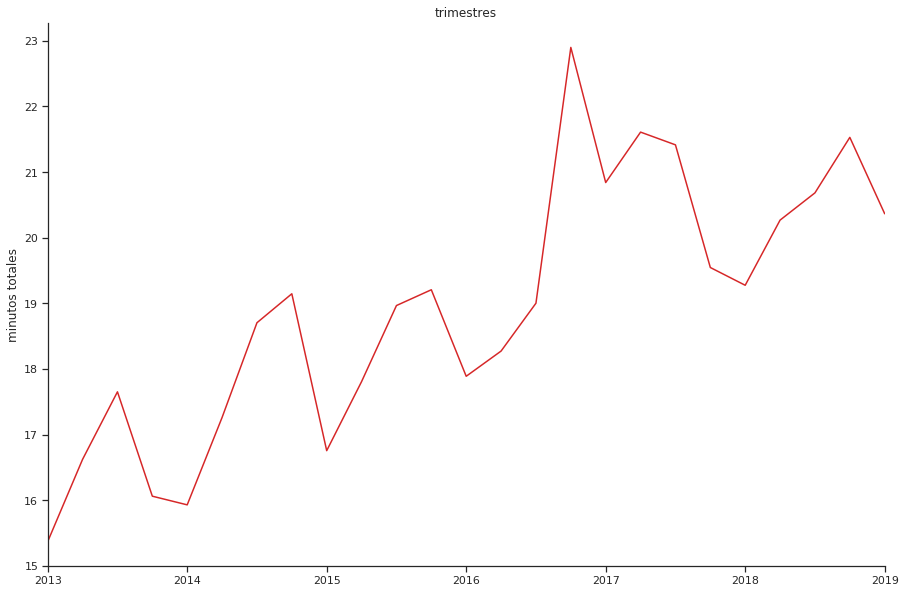

In [96]:
fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('minutos totales')
ax.set_title('trimestres')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [97]:
y.describe().round(2)


count    25.00
mean     18.92
std       1.98
min      15.37
25%      17.65
50%      19.00
75%      20.36
max      22.90
Name: Total de minutos salientes (miles), dtype: float64

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [98]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2019Q2    20.364355
2019Q3    20.364355
2019Q4    20.364355
2020Q1    20.364355
Freq: Q-DEC, dtype: float64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [99]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1.41

Using the formulas from the lecture, the interval forecasts are as below. 

In [100]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,17.602,23.127
2019Q3,16.457,24.271
2019Q4,15.579,25.150
2020Q1,14.839,25.890


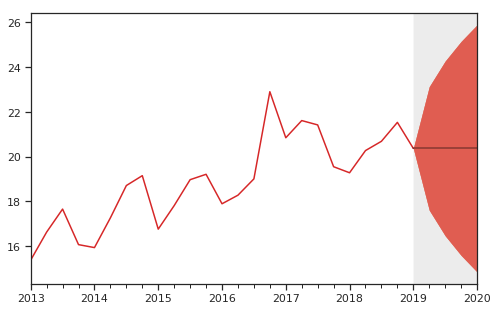

In [101]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2010':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [102]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Also AIC and BIC looks off so we are continue our analysis with MSE.

In [103]:
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1.737


You can calculate AIC and BIC as follows

In [104]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -42.378
 AIC               90.756
 BIC               94.413


Now, let's see how the smoothed data fits the original data

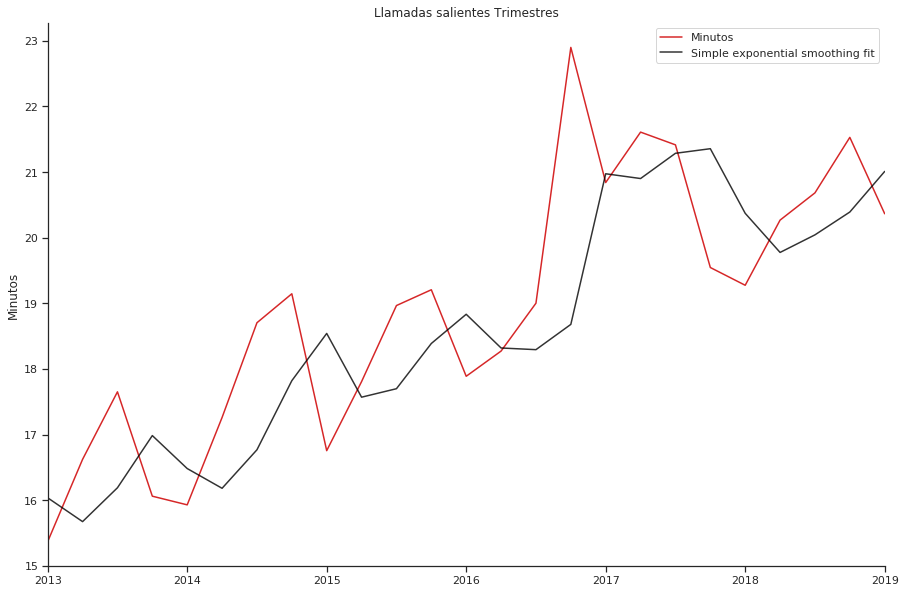

In [105]:
fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red, label='Minutos')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Llamadas salientes Trimestres')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

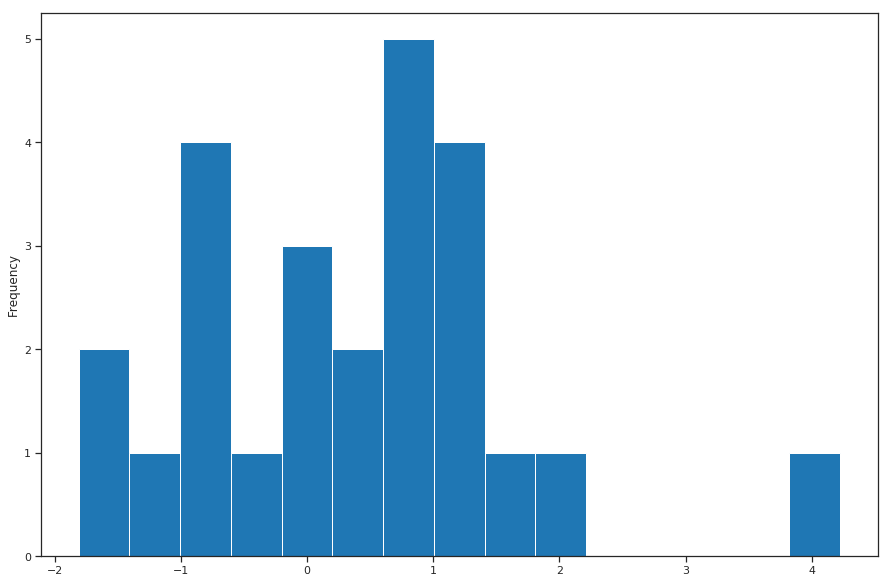

In [106]:
resid=y-fitted_ses
resid.plot.hist(bins=15)# model_ses.resid isn't a panda.Series, so no index, no plot

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

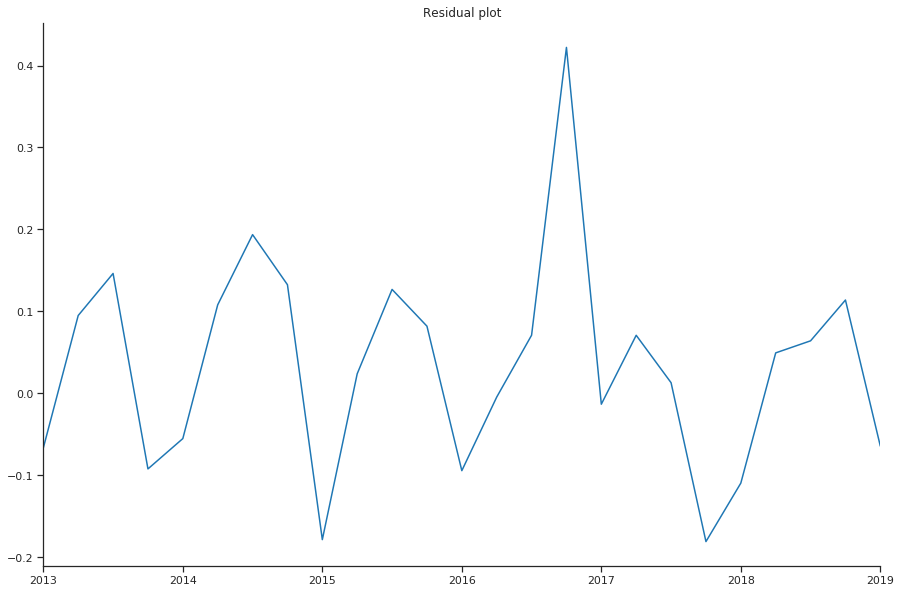

In [72]:
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Next is the residual ACF plot aka correlogram

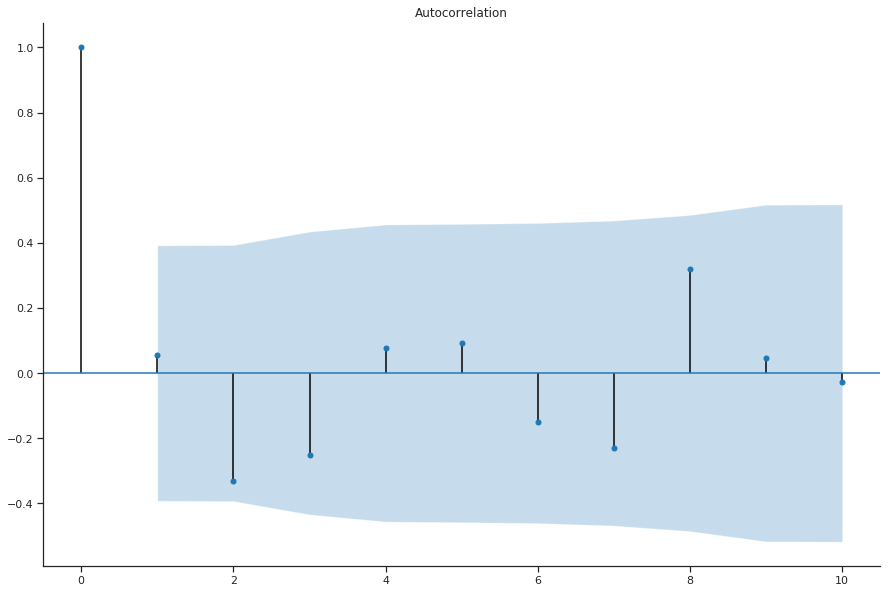

In [73]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax)
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

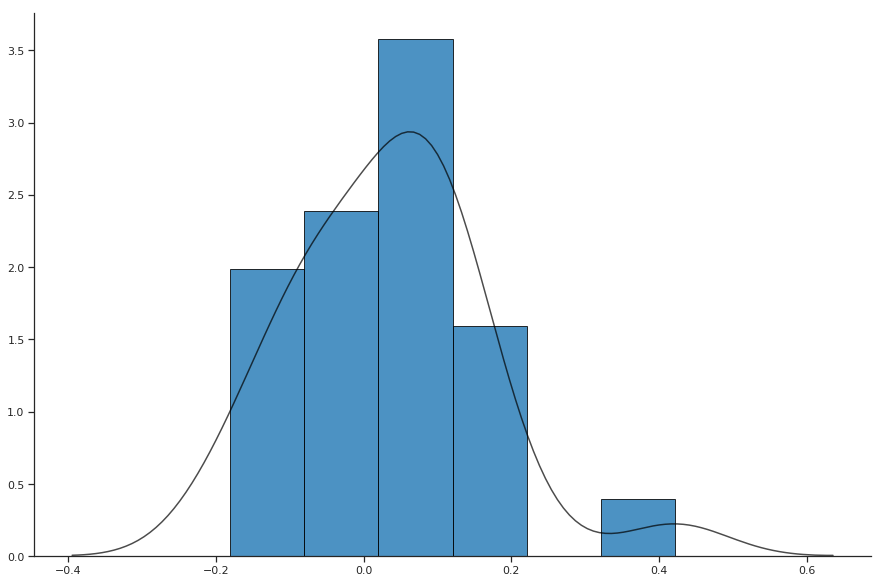

In [74]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [91]:
# Real time forecasting - use it as a template - expanding window

validation=y['2017Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2017Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
2018Q1,1.954526,2.037982,1.927456
2018Q2,1.927456,1.967791,2.026759
2018Q3,2.026759,2.003814,2.068278
2018Q4,2.068278,2.039671,2.152874
2019Q1,2.152874,2.106232,2.036436


We find that simple exponential smoothing generates more accurate forecasts. 

In [92]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,0.114,0.039
SES,0.115,0.039


## Forecast

We show how to do expanding and rolling point forecast. 

/home/lucia/anaconda3/envs/p36workshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)
/home/lucia/anaconda3/envs/p36workshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)


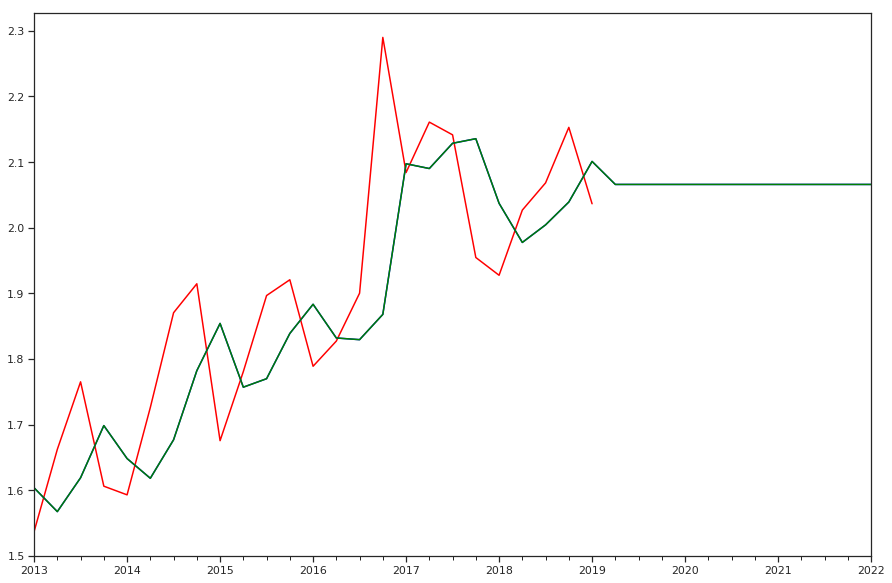

In [77]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

In this case, **statsmodels** doesn't provide interval forecast